# Randomized Benchmarking

A randomized benchmarking (RB) experiment consists of the generation of random Clifford circuits on the given qubits such that the unitary computed by the circuits is the identity. After running the circuits, the number of shots resulting in an error (i.e. an output different than the ground state) are counted, and from this data one can infer error estimates for the quantum device, by calculating the Error Per Clifford. 
See [Qiskit Textbook](https://qiskit.org/textbook/ch-quantum-hardware/randomized-benchmarking.html) for an explanation on the RB method, which is based on Ref. [1, 2].

In [1]:
import numpy as np
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library.randomized_benchmarking import RBUtils
import qiskit.circuit.library as circuits

# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeParis

backend = AerSimulator.from_backend(FakeParis())

## Standard RB experiment

To run the RB experiment we need to provide the following RB parameters, in order to generate the RB circuits and run them on a backend:


- `qubits`: The number of qubits or list of physical qubits for the experiment

- `lengths`: A list of RB sequences lengths 

- `num_samples`: Number of samples to generate for each sequence length

- `seed`: Seed or generator object for random number generation. If `None` then `default_rng` will be used

- `full_sampling`: If `True` all Cliffords are independently sampled for all lengths. If `False` for sample of lengths longer sequences are constructed by appending additional Clifford samples to shorter sequences. The default is `False`

The analysis results of the RB Experiment includes:

- `EPC`: The estimated Error Per Clifford

- `alpha`: The depolarizing parameter. The fitting function is $a \cdot \alpha^m + b$, where $m$ is the Clifford length

- `EPG`: The Error Per Gate calculated from the EPC, only for 1-qubit or 2-qubit quantum gates (see Ref. [3])

### Running a 1-qubit RB experiment

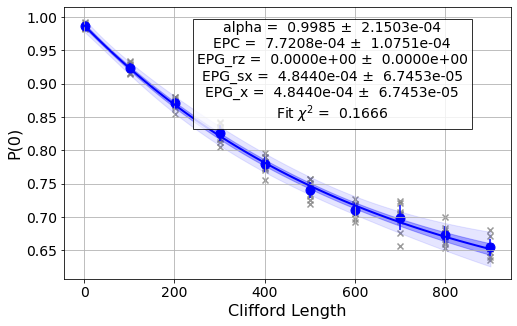

DbAnalysisResultV1
- name: @Parameters_RBAnalysis
- value: [0.4470869817805, 0.998455842530552, 0.5406146822253352]
- χ²: 0.1665544540307554
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.998455842530552 ± 0.0002150251206410919
- χ²: 0.1665544540307554
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0007720787347240132 ± 0.00010751256032054595
- χ²: 0.1665544540307554
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: EPG_rz
- value: 0.0 ± 0.0
- χ²: 0.1665544540307554
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: EPG_sx
- value: 0.0004843961464277781 ± 6.7452537635909e-05
- χ²: 0.1665544540307554
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: EPG_x
- value: 0.0004843961464277781 ± 6.7452537635909e-05
- χ²: 0.1665544540307554
- device_components: ['Q0']
- verified: False


In [2]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = [0]

# Run an RB experiment on qubit 0
exp1 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend).block_for_results()
results1 = expdata1.analysis_results()

# View result data
display(expdata1.figure(0))
for result in results1:
    print(result)

### Running a 2-qubit RB experiment

Running a 1-qubit RB experiment and a 2-qubit RB experiment, in order to calculate the gate error (EPG) of  the `cx` gate:

In [3]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = (1,4)

# Run a 1-qubit RB expriment on qubits 1, 4 to determine the error-per-gate of 1-qubit gates
expdata_1q = {}
epg_1q = []
lengths_1_qubit = np.arange(1, 1000, 100)
for qubit in qubits:
    exp = StandardRB([qubit], lengths_1_qubit, num_samples=num_samples, seed=seed)
    expdata = exp.run(backend).block_for_results()
    expdata_1q[qubit] = expdata
    epg_1q += expdata.analysis_results()

In [4]:
# Run an RB experiment on qubits 1, 4
exp2 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)

# Use the EPG data of the 1-qubit runs to ensure correct 2-qubit EPG computation
exp2.analysis.set_options(epg_1_qubit=epg_1q)

# Run the 2-qubit experiment
expdata2 = exp2.run(backend).block_for_results()

# View result data
results2 = expdata2.analysis_results()

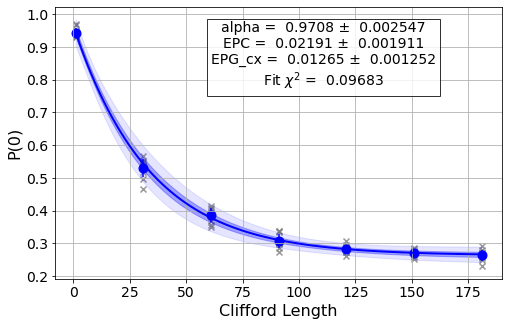

DbAnalysisResultV1
- name: @Parameters_RBAnalysis
- value: [0.6999018693318526, 0.9707842973975889, 0.26339637769272256]
- χ²: 0.09682971850757888
- extra: <4 items>
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9707842973975889 ± 0.002547458593241409
- χ²: 0.09682971850757888
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.02191177695180835 ± 0.0019105939449310565
- χ²: 0.09682971850757888
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: EPG_cx
- value: 0.012646485739645616 ± 0.0012516345880683845
- χ²: 0.09682971850757888
- device_components: ['Q1', 'Q4']
- verified: False


In [5]:
# View result data
display(expdata2.figure(0))
for result in results2:
    print(result)

In [6]:
# Compare the computed EPG of the cx gate with the backend's recorded cx gate error:
expected_epg = RBUtils.get_error_dict_from_backend(backend, qubits)[(qubits, 'cx')]
exp2_epg = expdata2.analysis_results("EPG_cx").value

print("Backend's reported EPG of the cx gate:", expected_epg)
print("Experiment computed EPG of the cx gate:", exp2_epg)

Backend's reported EPG of the cx gate: 0.012438847900902494
Experiment computed EPG of the cx gate: 0.012646485739645616 ± 0.0012516345880683845


### Displaying the RB circuits

Generating an example RB circuit:

In [7]:
# Run an RB experiment on qubit 0
exp = StandardRB(qubits=[0], lengths=[10], num_samples=1, seed=seed)
c = exp.circuits()[0]

We transpile the circuit into the backend's basis gate set:

In [8]:
from qiskit import transpile
basis_gates = backend.configuration().basis_gates
print(transpile(c, basis_gates=basis_gates))

global phase: 0
         ░ ┌───┐┌─────────┐ ░ ┌────────┐┌────┐┌────────┐ ░ ┌───┐┌─────────┐ ░ »
     q: ─░─┤ X ├┤ Rz(π/2) ├─░─┤ Rz(-π) ├┤ √X ├┤ Rz(-π) ├─░─┤ X ├┤ Rz(π/2) ├─░─»
         ░ └───┘└─────────┘ ░ └────────┘└────┘└────────┘ ░ └───┘└─────────┘ ░ »
meas: 1/══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ┌────────┐┌───┐ ░  ░ ┌──────────┐ ░ ┌────────┐┌────┐┌────────┐ ░ »
«     q: ┤ Rz(-π) ├┤ X ├─░──░─┤ Rz(-π/2) ├─░─┤ Rz(-π) ├┤ √X ├┤ Rz(-π) ├─░─»
«        └────────┘└───┘ ░  ░ └──────────┘ ░ └────────┘└────┘└────────┘ ░ »
«meas: 1/═════════════════════════════════════════════════════════════════»
«                                                                         »
«        ┌─────────┐┌────┐ ░ ┌────────┐┌────┐ ░ ┌────────┐┌────┐ ░ ┌────────┐»
«     q: ┤ Rz(π/2) ├┤ √X ├─░─┤ Rz(-π) ├┤ √X ├─░─┤ Rz(-π) ├┤ √X ├─░─┤ Rz(-π) ├»
«        └─────────┘└────┘ ░ └────────┘└────┘ 

## Interleaved RB experiment

Interleaved RB experiment is used to estimate the gate error of the interleaved gate (see Ref. [4]).

In addition to the usual RB parameters, we also need to provide:

- `interleaved_element`: the element to interleave, given either as a group element or as an instruction/circuit

The analysis results of the RB Experiment includes the following:

- `EPC`: The estimated error of the interleaved gate

- `alpha` and `alpha_c`: The depolarizing parameters of the original and interleaved RB sequences respectively

Extra analysis results include

- `EPC_systematic_err`: The systematic error of the interleaved gate error (see Ref. [4])

- `EPC_systematic_bounds`: The systematic error bounds of the interleaved gate error (see Ref. [4])


### Running a 1-qubit interleaved RB experiment

In [9]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = [0]

# Run an Interleaved RB experiment on qubit 0
# The interleaved gate is the x gate
int_exp1 = InterleavedRB(
    circuits.XGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata1 = int_exp1.run(backend).block_for_results()
int_results1 = int_expdata1.analysis_results()

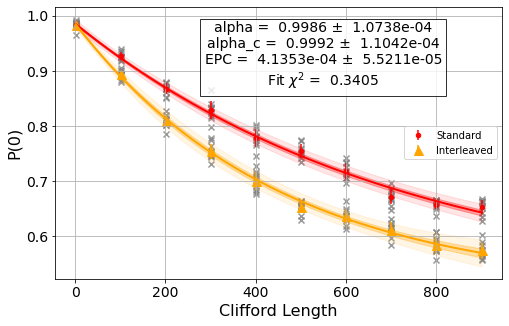

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.48273061532759726, 0.9986253053667937, 0.9991729396227305, 0.5028157100690334]
- χ²: 0.34047992917901276
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9986253053667937 ± 0.000107380924960653
- χ²: 0.34047992917901276
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9991729396227305 ± 0.00011042225382165526
- χ²: 0.34047992917901276
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.00041353018863476976 ± 5.521112691082763e-05
- χ²: 0.34047992917901276
- extra: <2 items>
- device_components: ['Q0']
- verified: False


In [10]:
# View result data
display(int_expdata1.figure(0))
for result in int_results1:
    print(result)

### Running a 2-qubit interleaved RB experiment

In [11]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [1,4]

# Run an Interleaved RB experiment on qubits 1, 4
# The interleaved gate is the cx gate
int_exp2 = InterleavedRB(
    circuits.CXGate(), qubits, lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata2 = int_exp2.run(backend).block_for_results()
int_results2 = int_expdata2.analysis_results()

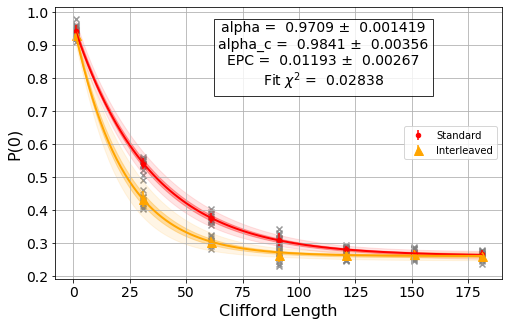

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.7017509412784269, 0.9708573040795396, 0.984098993152618, 0.26142882331425027]
- χ²: 0.028375809609823
- extra: <4 items>
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9708573040795396 ± 0.0014189312802870798
- χ²: 0.028375809609823
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.984098993152618 ± 0.003559505210678968
- χ²: 0.028375809609823
- device_components: ['Q1', 'Q4']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.011925755135536537 ± 0.002669628908009226
- χ²: 0.028375809609823
- extra: <2 items>
- device_components: ['Q1', 'Q4']
- verified: False


In [12]:
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

## Running a simultaneous RB experiment

We use `ParallelExperiment` to run the RB experiment simultaneously on different qubits (see Ref. [5])

In [13]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = range(3)

# Run a parallel 1-qubit RB experiment on qubits 0, 1, 2
exps = [StandardRB([i], lengths, num_samples=num_samples, seed=seed + i)
        for i in qubits]
par_exp = ParallelExperiment(exps)
par_expdata = par_exp.run(backend).block_for_results()
par_results = par_expdata.analysis_results()

# View result data
for result in par_results:
    print(result)
    print("\nextra:")
    print(result.extra)

DbAnalysisResultV1
- name: StandardRB
- value: a018a1cb-1d78-42d0-afa6-bbf7ee9ced79
- device_components: ['Q0']
- verified: False

extra:
{}
DbAnalysisResultV1
- name: StandardRB
- value: 04592a70-0a11-4349-9c3b-119897e42418
- device_components: ['Q1']
- verified: False

extra:
{}
DbAnalysisResultV1
- name: StandardRB
- value: de29cedd-2989-4cfc-8e9f-f972bddf997f
- device_components: ['Q2']
- verified: False

extra:
{}


### Viewing sub experiment data

The experiment data returned from a batched experiment also contains individual experiment data for each sub experiment which can be accessed using `child_data`

Component experiment 0


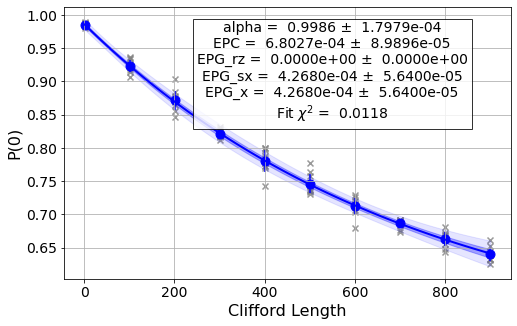

DbAnalysisResultV1
- name: @Parameters_RBAnalysis
- value: [0.4881092460900151, 0.9986394561167076, 0.498017486756109]
- χ²: 0.011803852807281667
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9986394561167076 ± 0.0001797913601252127
- χ²: 0.011803852807281667
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0006802719416462155 ± 8.989568006260635e-05
- χ²: 0.011803852807281667
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: EPG_rz
- value: 0.0 ± 0.0
- χ²: 0.011803852807281667
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: EPG_sx
- value: 0.0004267972840544035 ± 5.639984504740513e-05
- χ²: 0.011803852807281667
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: EPG_x
- value: 0.0004267972840544035 ± 5.639984504740513e-05
- χ²: 0.011803852807281667
- device_components: ['Q0']
- verified: False
Component experiment 1


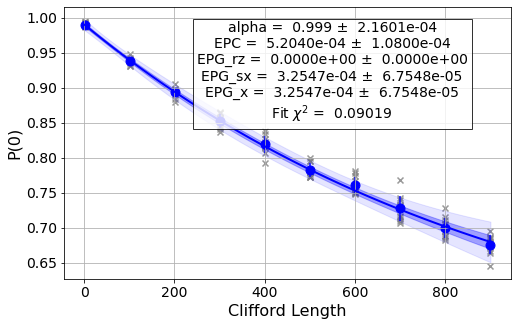

DbAnalysisResultV1
- name: @Parameters_RBAnalysis
- value: [0.510708139335162, 0.9989591954375782, 0.4795473918270127]
- χ²: 0.09019454074306014
- extra: <4 items>
- device_components: ['Q1']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9989591954375782 ± 0.00021600719888773847
- χ²: 0.09019454074306014
- device_components: ['Q1']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0005204022812109188 ± 0.00010800359944386923
- χ²: 0.09019454074306014
- device_components: ['Q1']
- verified: False
DbAnalysisResultV1
- name: EPG_rz
- value: 0.0 ± 0.0
- χ²: 0.09019454074306014
- device_components: ['Q1']
- verified: False
DbAnalysisResultV1
- name: EPG_sx
- value: 0.00032546990442990504 ± 6.754759242654973e-05
- χ²: 0.09019454074306014
- device_components: ['Q1']
- verified: False
DbAnalysisResultV1
- name: EPG_x
- value: 0.00032546990442990504 ± 6.754759242654973e-05
- χ²: 0.09019454074306014
- device_components: ['Q1']
- verified: False
Component experiment 2


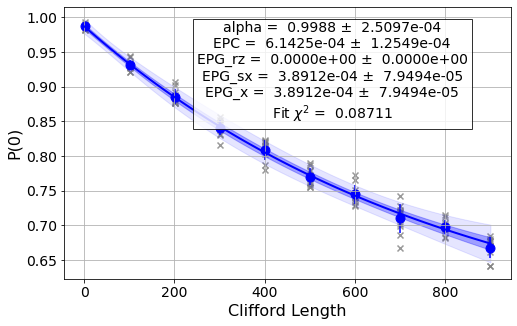

DbAnalysisResultV1
- name: @Parameters_RBAnalysis
- value: [0.4681047941559514, 0.9987714980174763, 0.518919324136702]
- χ²: 0.08711282265167093
- extra: <4 items>
- device_components: ['Q2']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9987714980174763 ± 0.00025097215949240054
- χ²: 0.08711282265167093
- device_components: ['Q2']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0006142509912618332 ± 0.00012548607974620027
- χ²: 0.08711282265167093
- device_components: ['Q2']
- verified: False
DbAnalysisResultV1
- name: EPG_rz
- value: 0.0 ± 0.0
- χ²: 0.08711282265167093
- device_components: ['Q2']
- verified: False
DbAnalysisResultV1
- name: EPG_sx
- value: 0.00038912012233391574 ± 7.949382157566733e-05
- χ²: 0.08711282265167093
- device_components: ['Q2']
- verified: False
DbAnalysisResultV1
- name: EPG_x
- value: 0.00038912012233391574 ± 7.949382157566733e-05
- χ²: 0.08711282265167093
- device_components: ['Q2']
- verified: False


In [14]:
# Print sub-experiment data
for i, sub_data in enumerate(par_expdata.child_data()):
    print(f"Component experiment {i}")
    display(sub_data.figure(0))
    for result in sub_data.analysis_results():
        print(result)

## References

[1] Easwar Magesan, J. M. Gambetta, and Joseph Emerson, *Robust randomized benchmarking of quantum processes*, https://arxiv.org/pdf/1009.3639

[2] Easwar Magesan, Jay M. Gambetta, and Joseph Emerson, *Characterizing Quantum Gates via Randomized Benchmarking*, https://arxiv.org/pdf/1109.6887

[3] David C. McKay, Sarah Sheldon, John A. Smolin, Jerry M. Chow, and Jay M. Gambetta, *Three Qubit Randomized Benchmarking*, https://arxiv.org/pdf/1712.06550

[4] Easwar Magesan, Jay M. Gambetta, B. R. Johnson, Colm A. Ryan, Jerry M. Chow, Seth T. Merkel, Marcus P. da Silva, George A. Keefe, Mary B. Rothwell, Thomas A. Ohki, Mark B. Ketchen, M. Steffen, 
*Efficient measurement of quantum gate error by interleaved randomized benchmarking*,
https://arxiv.org/pdf/1203.4550

[5] Jay M. Gambetta, A. D. C´orcoles, S. T. Merkel, B. R. Johnson, John A. Smolin, Jerry M. Chow, Colm A. Ryan, Chad Rigetti, S. Poletto, Thomas A. Ohki, Mark B. Ketchen, and M. Steffen, *Characterization of addressability by simultaneous randomized benchmarking*, https://arxiv.org/pdf/1204.6308



In [15]:
import qiskit.tools.jupyter
%qiskit_copyright